In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

### Finite Element Method formulation
It discretizes wave equation on a structured mesh using quad Whitney.

In [2]:
using SparseArrays
struct WaveEquationDiscretization
    # degrees of freedom
    ndof :: Int64
    dof  :: Vector{Int64}
    # boundary markers
    Γ :: Vector{Int8}
    # linear operators
    S :: SparseMatrixCSC{Float64, Int64}
    R :: SparseMatrixCSC{Float64, Int64}
    T :: SparseMatrixCSC{Float64, Int64}
    B :: SparseMatrixCSC{Float64, Int64}
    # nonlinear operators
    F  :: Vector{Float64}
    J  :: SparseMatrixCSC{Float64, Int64}
    # circuit coupling
    i    :: Vector{Float64}
    didv :: SparseMatrixCSC{Float64, Int64}
    # state vectors
    e   :: Vector{Float64} # t
    ep  :: Vector{Float64} # t -  Δt
    epp :: Vector{Float64} # t - 2Δt
    h   :: Vector{Float64} # t
    hp  :: Vector{Float64} # t -  Δt
    hpp :: Vector{Float64} # t - 2Δt
    function WaveEquationDiscretization(ndof :: Int64)
        new(
            ndof, collect(1:ndof),
            zeros(Int8, ndof),
            spzeros(ndof, ndof), spzeros(ndof, ndof), spzeros(ndof, ndof), spzeros(ndof, ndof),
            zeros(ndof), spzeros(ndof, ndof),
            zeros(ndof), spzeros(ndof, ndof),
            zeros(ndof), zeros(ndof), zeros(ndof),
            zeros(ndof), zeros(ndof), zeros(ndof) 
        )
    end
end

function lhs(model, Δt)
    S, R, T, B = model.S, model.R, model.T, model.B
    return (0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
end

function lhs!(A, model, Δt) end # make it memory efficient
function pec!(A, model, boundary)
    ndof = model.ndof
    dof = model.dof
    Γ = model.Γ
    
    for ii = 1:ndof
      if Γ[ii] == boundary
            A[:,dof[ii]].= 0.0
            A[dof[ii],:].= 0.0
            A[dof[ii], dof[ii]] = 1.0
      end
    end
end
function rhs(model, Δt)
    ep, epp = model.ep, model.epp
    S, R, T, B = model.S, model.R, model.T, model.B
    return (0.25Δt^2 * S +  T - 0.5Δt * B - 0.5Δt * R) * epp +
           (0.50Δt^2 * S - 2T) * ep
           
end

function rhs!(b, model, Δt) end # make it memory efficient

rhs! (generic function with 1 method)

In [3]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(lx, ly, x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]

abc (generic function with 1 method)

### Basic parameters of the simulation
The simulation starts with an uncharged Blumlein pulse former and it charges its both lines to a high voltage through a 3kΩ resistor.



In [4]:
# Circuit
Z0 = 13.2 # Ω is the charactersitic impedance of each of the two transmission lines
RL = 2Z0  # Ω
Rs = 3000 # Ω
V0 = 5000 # V

# Parameters
Δt = 0.05e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
nothing

### Meshing
A simple, structured mesh is generated

In [5]:
struct QuadMesh
    a :: Float64
    b :: Float64
    n :: Int64
    m :: Int64
    # mesh
    nedges :: Int64
    # connectivity
    el2ed :: Matrix{Int64}
    el2edd :: Matrix{Int64}
end

const mesh = let
    a, b = 2.00, 0.08
    n, m = 100, 4
    lx = a / n
    ly = b / m
    el2ed, el2edd = quadmesh(a, b, n, m)
    QuadMesh(a, b, n, m, 2*n*m + n + m, el2ed, el2edd)
end

const model = WaveEquationDiscretization(mesh.nedges);

#### Boundary markers
To allow easier handling different boundary conditions, each edge has an associated boundary marker.
There is a default, empty marker with the value of 0.

In [6]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_LOAD = 4
DOF_SG   = 5

function mark!(boundary, mesh)
    n, m = mesh.n, mesh.m
    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]
    start, stop = extrema(h[3])
    h[3] = start:stop - 5
    
    boundary[(h[1])] .= DOF_PEC # BOTTOM
    boundary[(h[3])] .= DOF_PEC # MIDDLE
    boundary[(h[5])] .= DOF_PEC # TOP
    
    boundary[first(v[1])] = DOF_SRC
    boundary[first(v[2])] = DOF_SRC
    
    boundary[first(v[3])] = DOF_SG
    boundary[first(v[4])] = DOF_SG
    
    boundary[ last(v[1])] = DOF_LOAD
    boundary[ last(v[2])] = DOF_LOAD
    boundary[ last(v[3])] = DOF_LOAD
    boundary[ last(v[4])] = DOF_LOAD
    return nothing
end
mark!(model.Γ, mesh)

### Procedures for assembling the system of linear equations
During the assembly operation stiffness and mass are precomputed and later used for building the matrix **A**. After that, PEC (Dirichlet) boundary condition is being applied.

In [7]:
function assemble!(model, mesh; μr=1.0, εr=1.0, η=sqrt(μ0/ε0))
    nelems = mesh.n*mesh.m
    lx, ly = mesh.a/mesh.n,
             mesh.b/mesh.m
    el2edd = mesh.el2edd
    el2ed  = mesh.el2ed
    dof    = model.dof
    S, T   = model.S, model.T
    R, B   = model.R, model.B
    
    ε = εr * ε0
    # ASSUMPTION: Waveguide is homogenous
    for ielem = 1:nelems # Assemble by elements
      Se = stiffness_element(lx, ly)
      Te = mass_element(lx, ly)
      Be = abc(lx, ly, n̂) # works only for x̂ normal direction

      for jedge = 1:4
        dj = el2edd[ielem, jedge]
        jj = dof[el2ed[ielem, jedge]]
        if jj == 0
          continue
        end

        for kedge = 1:4
          dk = el2edd[ielem, kedge]
          kk = dof[el2ed[ielem, kedge]]
          if kk == 0
            continue
          end

          S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
          T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]


          if model.Γ[jj] == DOF_ABC
            B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
          end
        end
      end
    end
end

assemble!(model, mesh)
const A = lhs(model, Δt)
pec!(A, model, DOF_PEC)

### Circuit model of a spark gap
This model is based on the paper by Pouncey and Lehr (2015). It uses ACME.jl for simulation of electric circuit representing the arc channel.

In [8]:
using StaticArrays
using ACME

mm = 1e-3 # m
atm = 101_325.0 # Pa
gasdensity(p) = 1.2p/1atm # at 25 degrees C.
electricfield(V, d) = V/d

# channel radius
# ρ in [kg/m3], i in [A], t in [s], result in [m]
braginskii(ρ, i, t) = 9.3e-4 * (1e-3*i)^(1/3) *
                               (1e+6*t)^(1/2) *
                               (1e-3*ρ)^(1/6)
# breakdown delay
# E in [V/m], ρ in [kg/m3], result in [s]
thmartin(E, ρ) = (987e2/1e-3ρ) * (1e-5E/1e-3ρ)^(-3.44)

# breakdown voltage
# p in [Pa], d in [m], result in [V]
bruce(p, d) = 24550 *     (1e2d * p / 1atm) + 
               6660 * sqrt(1e2d * p / 1atm)

# wire inductance
# r in [m], d in [m], result in [H] 
grover(r, d) = 200e-9d * (log(200d / r) - .75)

# arc resistance
# r in [m], d in [m], i in [A], result in [Ω]
vlastos(r, d, ∫i²) = 876d * r^(2/5) / ∫i²^(3/5)

nonlinear_eq = @inline function(q, params)
    v, i, Φ, u = q
    if params["channel_on"] == false
        j = @SVector [(v - u), (i)]
        J = @SMatrix [(1) (0.) (.0) (-1);
                      (0) (1.) (.0) (.0)] 
    else
        if i ≈ 0.0 i = 1e-12 end
        ch_rad = braginskii(gasdensity(params["pressure"]), abs(i), params["t_arc"])
        Ri  = vlastos(ch_rad, params["distance"], params["∫i²"] + (i^2) * params["Δt"]) * i
        dRi = -14.2497 * params["distance"] *
            (abs(i)^(1/3)* gasdensity(params["pressure"])^(1/6) * params["t_arc"]^(1/2)) /
                (i^2 * params["t_arc"])^(3/5)
        Li  = grover(ch_rad, params["distance"])*i
        dLi = 2.0e-7 * params["distance"] *
            (log((215054. * params["distance"]) / 
                (abs(i)^(1/3)* gasdensity(params["pressure"])^(1/6) * params["t_arc"]^(1/2))) -
            1.08333) 

        j = @SVector [(Ri - u), (Li - Φ)]
        J = @SMatrix [(0) (dRi) (.0) (-1);
                      (0) (dLi) (-1) (.0)] 
    end
    return (j, J)
    end

afternewton = @inline function(q, params)
    v, i, Φ, u = q
    i = value(i)
    if params["channel_on"]
        if i > params["i_min"]
            params["t_arc"] += params["Δt"]
            params["∫i²"] += i^2 * params["Δt"]
        else
            params["channel_on"] = false
            params["∫i²"] = 0.0
            params["t_arc"] = 0.0
        end
    elseif v > params["v_break"]
        t_delay = thmartin(electricfield(v,params["distance"]), gasdensity(params["pressure"]))
        params["t_over"] += params["Δt"]
        if params["t_over"] > t_delay
            params["channel_on"] = true
            params["∫i²"] = i^2 * params["Δt"]
            params["t_arc"] = params["Δt"]
            params["t_over"] = 0.0
        end
    end
end

arcchannel() =
  ACME.Element(mv=[1;1;0;0;0], mi=[0;0;1;0;0], mx=[0 -1;0 0;0 0;1 0;0 1], mxd=[-1 0;0 0;0 0;0 0;0 0],
        mq=[0 0 0 0;-1 0 0 0;0 -1 0 0; 0 0 -1 0; 0 0 0 -1], ports=[:1 => :2],
        nonlinear_eq = nonlinear_eq)

include("automatic-differentiation.jl")
include("circuit-model.jl")
const sparkgap = include("circuit-spark-gap.jl")
const voltage = include("circuit-voltage-source.jl")
const antenna = include("circuit-dipole-antenna.jl")
nothing

### Field-Circuit coupling procedure
As the field simulations tries to determine voltages across edges of the finite element mesh, the coupling procedure calculates the currents flowing through the edges. The voltages across edges are represented as voltage sources in the electrical circuit. As the current might depend in a nonlinear way on the edge's voltage, we solve it using Newton method. This means, that from the electrical circuit we need both the currents and the derivatives of the currents with respect to the voltages.

In [9]:
sigmoid(x) = 1.0 / (1.0 + exp(-10x))
Rsp(τ) = sigmoid(τ - 1.0)

function calculate_current(model, mesh, boundary)
    i = 0.0
    for ii = 1:model.ndof
        jj = model.dof[ii]
        if model.Γ[ii] == boundary
            i += model.i[jj]
        end
    end
    return i
end

function calculate_voltage(model, mesh, boundary)
    v = 0.0
    for ii = 1:model.ndof
        jj = model.dof[ii]
        if model.Γ[ii] == boundary
            v += model.e[jj]
        end
    end
    return v
end

function assemble_circuit_element(element::SparkGap, v)
    return first(step!(element.model, v, element.nonlinear_eq))
end

function assemble_circuit_element(element::VoltageSource, v)
    return first(step!(element.model,[v; V0]))
end

function assemble_circuit_element(element::LinearOnePortElement, v)
    return first(step!(element.model, v))
end


function advance_element!(model, mesh, element, boundary)
    u = calculate_voltage(model, mesh, boundary)
    y = assemble_circuit_element(element, u)
    
    return first(u), value(first(y))
end

function assemble_circuit!(model, mesh, circuit)
    for (boundary, element) in circuit
        u = calculate_voltage(model, mesh, boundary)
        y = assemble_circuit_element(copy(element), u + ϵ)

        k = mesh.m
        for ii = 1:model.ndof
            jj = model.dof[ii]

            if model.Γ[ii] == boundary
                model.i[jj] =       k * y.v
                model.didv[jj,jj] = k * y.dv
            end
        end
    end
    
    return nothing
end

assemble_circuit! (generic function with 1 method)

### Nonlinear procedure for solving field-circuit coupling
It has to be noted that there are possibly two Newton iterations:
- the first one is used to determine the current through the mesh edge for a *fixed* edge voltage (circuit only),
- the second one is for determining the edge voltage so that is in equilibrium with the current through that edge (field-circuit coupling).

In [10]:
function assemble_nonlinear!(model, A, b, Δt)
    ly   = mesh.b/mesh.m
    e,i  = model.e, model.i
    hpp  = model.hpp
    didv = model.didv
    
    model.F .= A*e + 0.5Δt * ly^2 * μ0 * i - 0.5Δt * ly^2 * μ0 * hpp + b
    model.J .= A   + 0.5Δt * ly^2 * μ0 * didv
end

assemble_nonlinear! (generic function with 1 method)

### Initial conditions
In this place it should be possible to recover some stored simulator's state.

In [11]:
using JLD2

const nt  = 40_000
const x = 0.010:0.050:0.51
const y = 0.005:0.012:0.07
const chon = zeros(Bool, nt)
const res = zeros(nt, 11, 6, 2)
const vRsg = zeros(nt)
const vRL  = zeros(nt)
const vRs  = zeros(nt)
const iRsg = zeros(nt)
const iRL  = zeros(nt)
const iRs  = zeros(nt)
nothing

In [12]:
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)

function solve!(model, mesh, circuit, Δt, nt)
    t  = 0.0
    Δe = similar(model.e)
    progress = Progress(nt)
    element = WhitneyRectangleElement()
    
    for it = 1:nt
        b = rhs(model, Δt)
        # Newton method
        N = 0
        Δe .= Inf
        while norm(Δe) > 1e-12 && N < 10
            assemble_circuit!(model, mesh, circuit)
            assemble_nonlinear!(model, A, b, Δt)
            Δe .= model.J\model.F
            model.e .-= Δe
            N += 1
        end

        # Timestep
        vRsg[it],iRsg[it]= advance_element!(model, mesh, sparkgap, DOF_SG)
        vRL[it], iRL[it] = advance_element!(model, mesh, antenna, DOF_LOAD)
        vRs[it], iRs[it] = advance_element!(model, mesh, voltage, DOF_SRC)
        afternewton(sparkgap.model.q̄, sparkgap.model.params)
        chon[it] = sparkgap.model.params["channel_on"]

        model.epp .= model.ep
        model.ep  .= model.e
        model.hpp .= model.hp
        model.hp  .= model.i

        # Gather results
        res[it,:,:,:] = evaluate(element,
           model.e, model.dof,
           x, y,
           mesh.n, mesh.m,
           mesh.a/mesh.n, mesh.b/mesh.m,
           mesh.el2ed, mesh.el2edd)

        t += Δt
        update!(progress, it; showvalues=[
                (:t, t),
                (:nonlinear, norm(Δe)),
                (:channel, chon[it]),
                (:Vsg, vRsg[it]),
                (:VL, vRL[it])
                ])
    end
end
const circuit = Dict{Int8, Any}(DOF_SG => sparkgap, DOF_LOAD => antenna, DOF_SRC => voltage)
@time solve!(model, mesh, circuit, Δt, 1)
@time solve!(model, mesh, circuit, Δt, nt)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:29
  t:          1.999999999998321e-6
  nonlinear:  2.478668699497807e-12
  channel:    false
  Vsg:        3600.5268327183476
  VL:         3248.567291018868


149.422798 seconds (245.01 M allocations: 258.613 GiB, 4.28% gc time, 0.36% compilation time)


### Results
Ah! At last, a visualization of the simulation results.

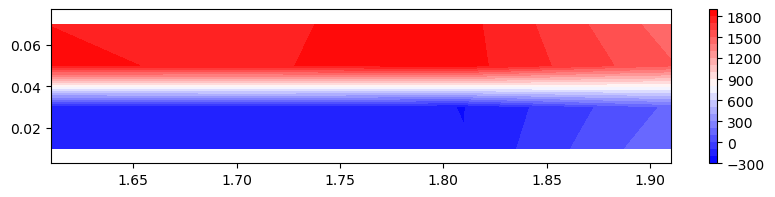

(-201.90415198935642, 1838.5153271345046)

In [13]:
import PyPlot: contourf, plot, figure, xlabel, ylabel, xlim, ylim, axis, grid, legend, title, get_cmap, colorbar
xx, yy, Ey = let
    x = 1.61:0.10:2.00
    y = 0.01:0.02:0.08
    E = evaluate(WhitneyRectangleElement(),
       model.e, model.dof,
       x, y,
       mesh.n, mesh.m,
       mesh.a/mesh.n, mesh.b/mesh.m,
       mesh.el2ed, mesh.el2edd)
    normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
    xx, yy = meshgrid(x, y);
    xx, yy, E[:, :, 2]
end

figure(figsize=(10, 2))
contourf(xx', yy', Ey, cmap=get_cmap("bwr"), levels=20)
axis("equal"); colorbar();
extrema(Ey)

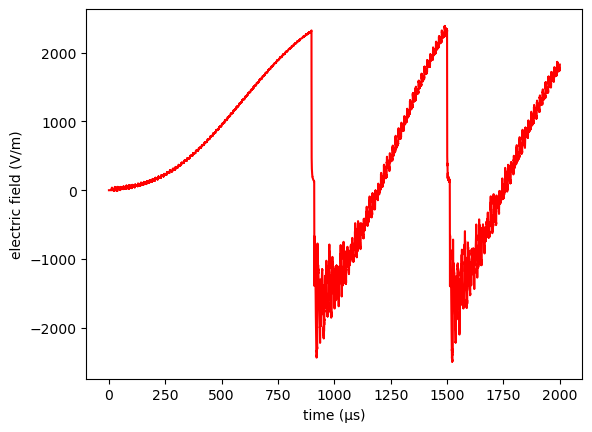

PyObject Text(24.0, 0.5, 'electric field (V/m)')

In [14]:
ts = 1e9Δt * collect(1:nt)
#plot(ts, res[:, 3, 1, 2], "r-")
plot(ts, res[:, 3, 6, 2], "r-")
#plot(ts, res[:, 9, 1, 2], "b-")
#plot(ts, res[:, 9, 6, 2], "b-")
xlabel("time (μs)")
ylabel("electric field (V/m)")

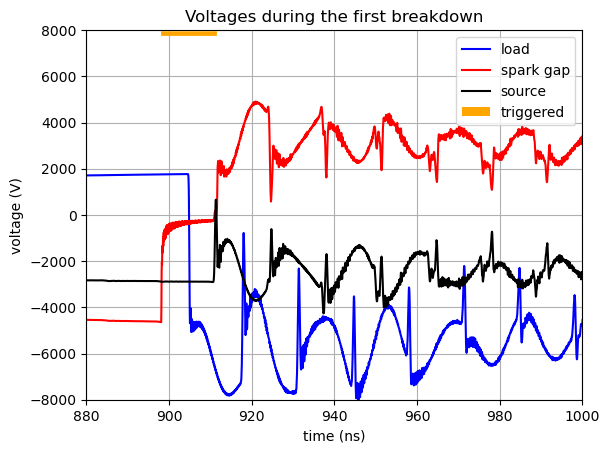

PyObject <matplotlib.legend.Legend object at 0x7fed004cc2e0>

In [19]:
import PyPlot: gca
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, vRL, "b-")
plot(ts,-vRsg, "r-")
plot(ts, vRs, "k-")
gca().
fill_between(ts, 7950 .- 200chon, 7950, fc="orange", zorder=999)
xlim([880, 1000])
ylim([-8000,+8000])
ylabel("voltage (V)")
title("Voltages during the first breakdown")
legend(["load", "spark gap", "source", "triggered"])

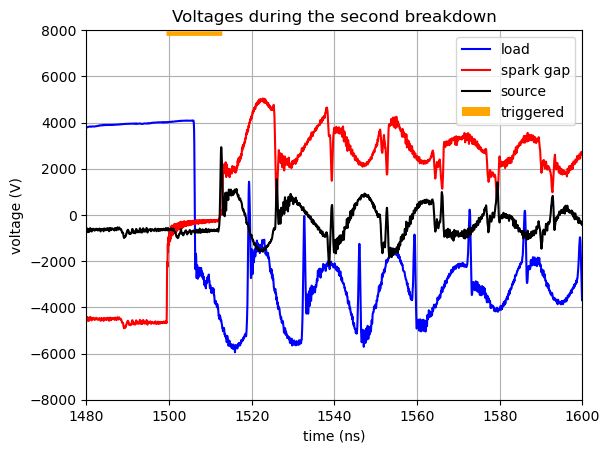

PyObject <matplotlib.legend.Legend object at 0x7fecc00e0d90>

In [20]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, vRL, "b-")
plot(ts,-vRsg, "r-")
plot(ts, vRs, "k-")
gca().
fill_between(ts, 7950 .- 200chon, 7950, fc="orange", zorder=999)
xlim([880, 1000])
xlim([1480, 1600])
ylim([-8000,+8000])
ylabel("voltage (V)")
title("Voltages during the second breakdown")
legend(["load", "spark gap", "source", "triggered"])

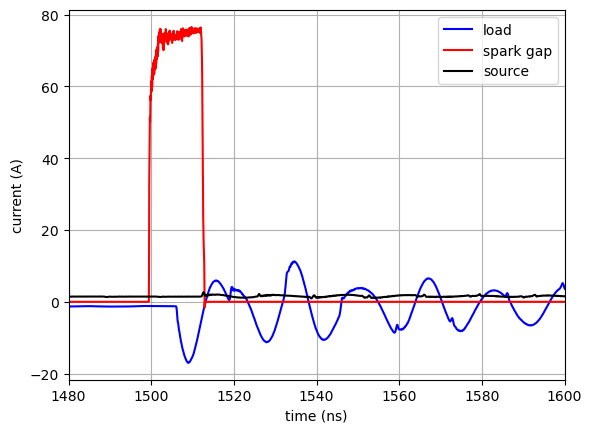

PyObject <matplotlib.legend.Legend object at 0x7fece1c877c0>

In [17]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, iRL, "b-")
plot(ts, iRsg, "r-")
plot(ts, iRs, "k-")
xlim([1480, 1600])
ylabel("current (A)")
legend(["load", "spark gap", "source"])

In [18]:
using JLD2
jldsave("blumlein-sparkgap.jld2"; model=model, mesh=mesh, circuit=circuit)